Data loaded successfully!
Supply: (3, 24), Demand: (10, 24)
Loss: (3, 10), Cost: (3, 1)

Supply Data Sample:
           Hour_0      Hour_1      Hour_2      Hour_3      Hour_4      Hour_5  \
Solar    9.934283    0.000000   12.953771   30.460597    0.000000   75.317261   
Wind   294.674073  498.010859  434.973223  644.524267  483.996132  420.613012   
Hydro  408.590457  369.413835  434.081297  426.914741  427.471211  464.246112   

           Hour_6      Hour_7      Hour_8      Hour_9  ...     Hour_14  \
Solar  271.584256  495.348695  630.610512  730.851201  ...  605.501643   
Wind   255.115211  430.812276  132.237712   60.000000  ...  435.597855   
Hydro  475.658427  470.395049  419.868057  423.824088  ...  340.787228   

          Hour_15     Hour_16     Hour_17     Hour_18     Hour_19     Hour_20  \
Solar  468.754249  219.743378   86.284947    0.000000    0.000000   29.312975   
Wind   609.765970  600.077096  413.244190  250.505945  127.794782   60.000000   
Hydro  329.246340  373.200

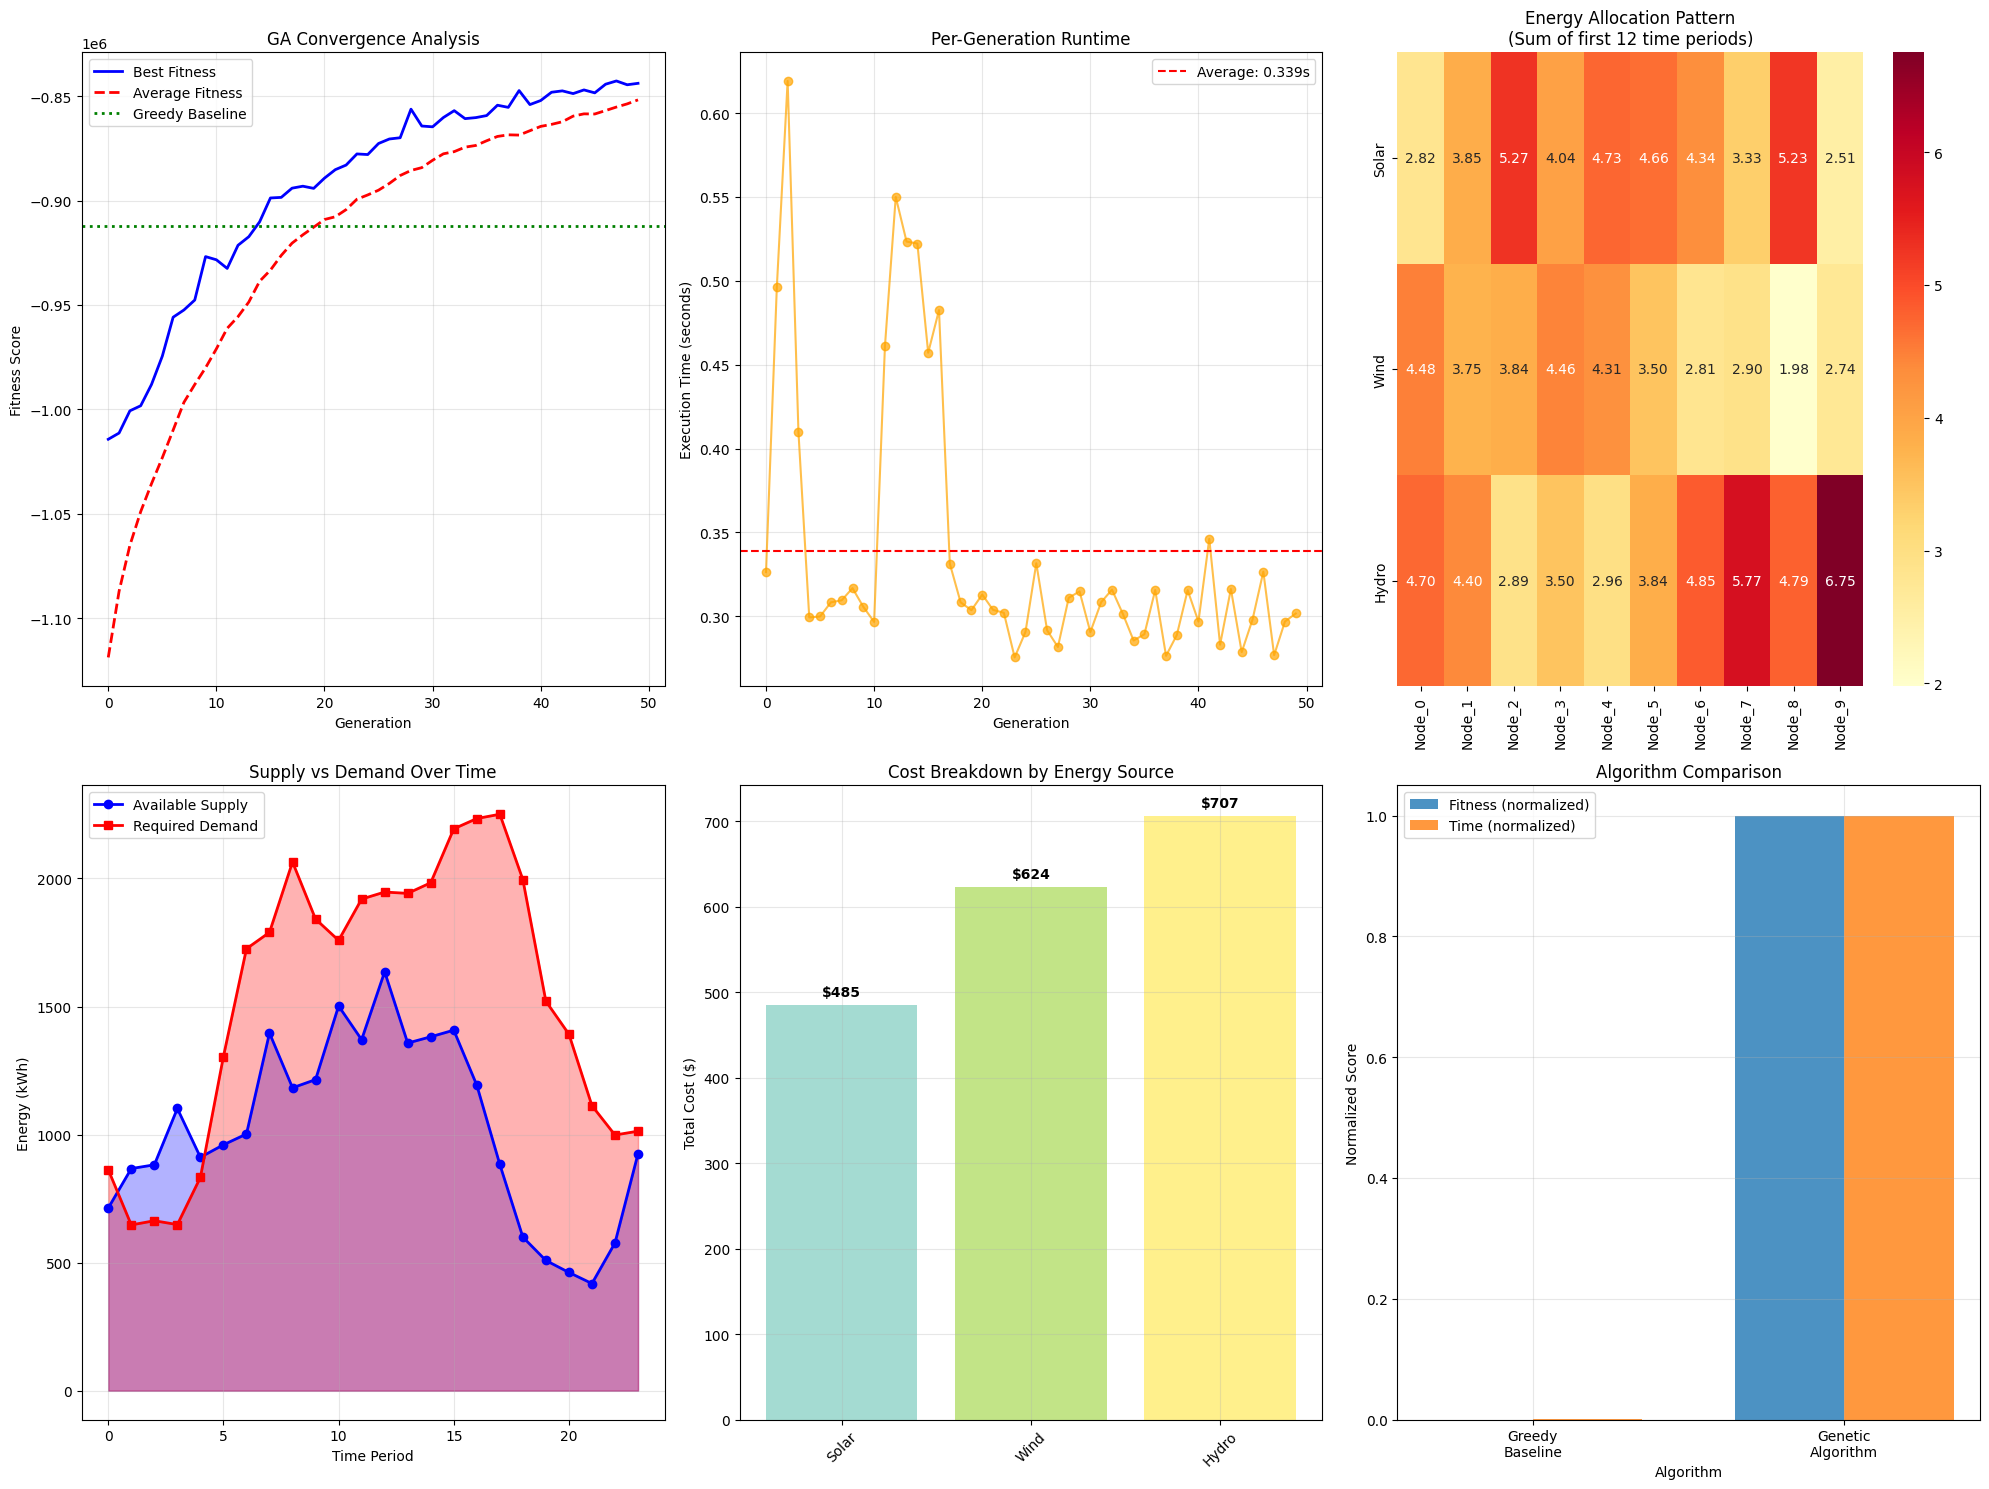


PARAMETER SENSITIVITY ANALYSIS

Testing population size: 50

Starting GA with 50 individuals for 30 generations
Parallel processing: True
Generation 0: Best=-1011051.82, Avg=-1115525.75, Time=0.21s
Generation 10: Best=-924994.10, Avg=-951070.40, Time=0.20s
Generation 20: Best=-888819.48, Avg=-900595.66, Time=0.18s

GA completed in 5.61 seconds
Best fitness: -866493.27

Testing population size: 100

Starting GA with 100 individuals for 30 generations
Parallel processing: True
Generation 0: Best=-1022316.85, Avg=-1124841.10, Time=0.29s
Generation 10: Best=-922781.82, Avg=-960639.68, Time=0.47s
Generation 20: Best=-880047.26, Avg=-897065.73, Time=0.30s

GA completed in 10.52 seconds
Best fitness: -868719.66

Testing population size: 150

Starting GA with 150 individuals for 30 generations
Parallel processing: True
Generation 0: Best=-1018388.59, Avg=-1121554.81, Time=0.47s
Generation 10: Best=-915363.68, Avg=-948236.82, Time=0.74s
Generation 20: Best=-874455.94, Avg=-896297.09, Time=0.44

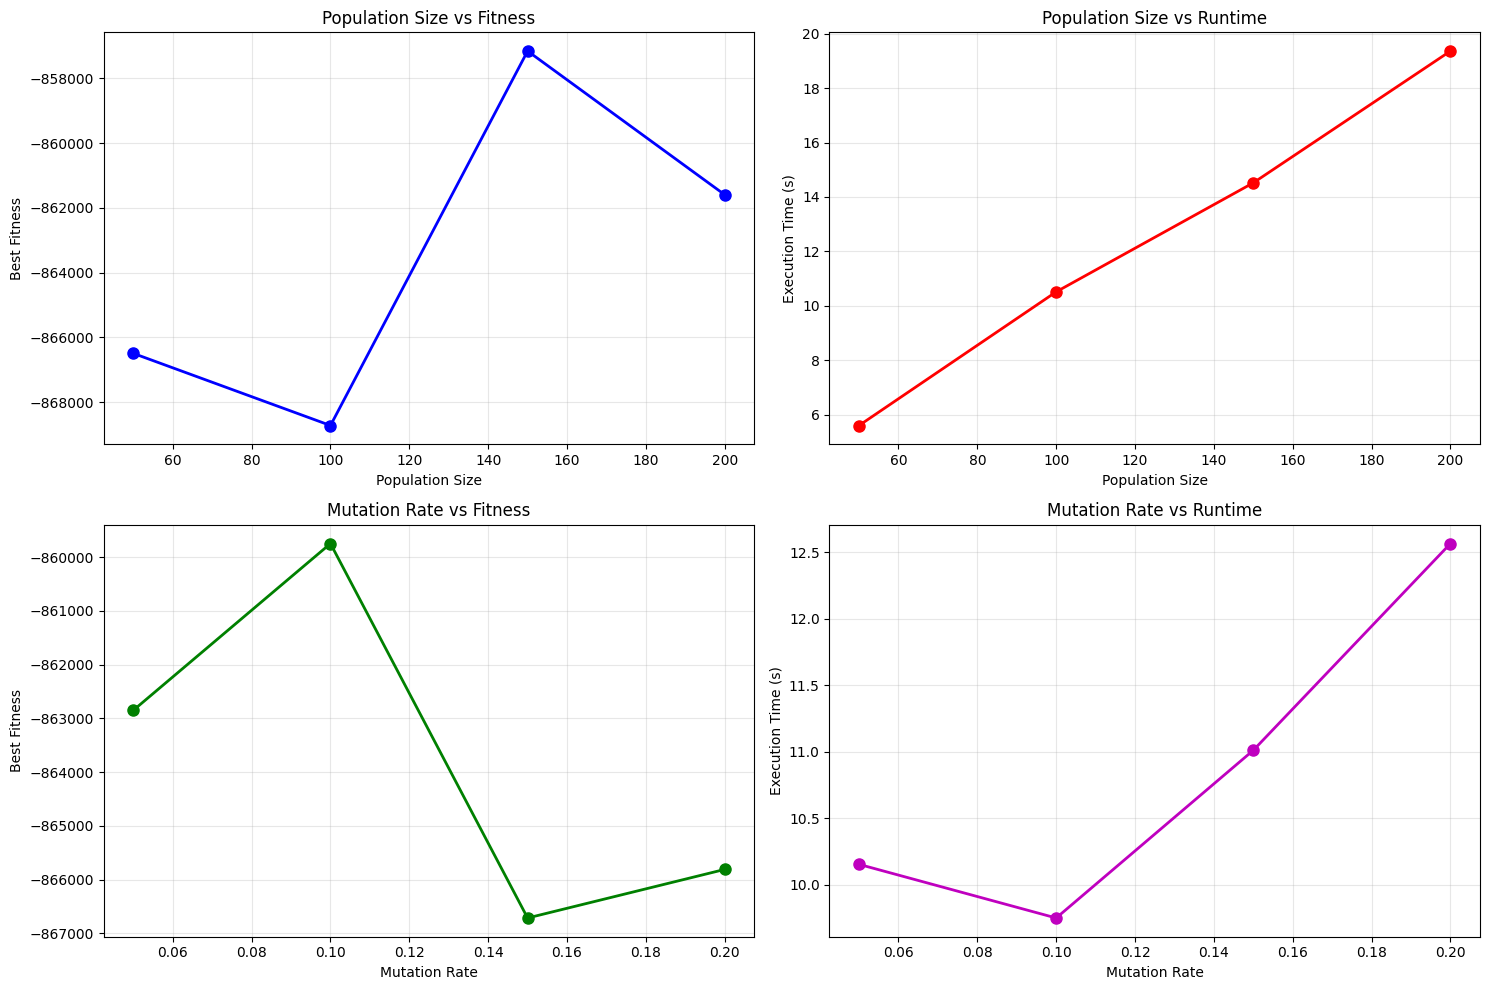


Results exported to CSV files:
- ga_best_allocation.csv
- ga_fitness_history.csv
- algorithm_comparison.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool, cpu_count
import time
import random
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility to ensure consistent results across runs
np.random.seed(42)
random.seed(42)

class SmartGridOptimizer:
    def __init__(self, supply_file, demand_file, loss_file, cost_file):
        """Initialize the Smart Grid Optimizer with data files containing supply, demand, loss, and cost data"""
        self.load_data(supply_file, demand_file, loss_file, cost_file)
        self.setup_problem_parameters()

    def load_data(self, supply_file, demand_file, loss_file, cost_file):
        """Load and preprocess all data files into pandas DataFrames for analysis"""
        try:
            self.supply_data = pd.read_csv(supply_file, index_col=0)  # Load supply data with first column as index
            self.demand_data = pd.read_csv(demand_file, index_col=0)  # Load demand data with first column as index
            self.loss_data = pd.read_csv(loss_file, index_col=0)      # Load loss data with first column as index
            self.cost_data = pd.read_csv(cost_file, index_col=0)      # Load cost data with first column as index

            print(f"Data loaded successfully!")
            print(f"Supply: {self.supply_data.shape}, Demand: {self.demand_data.shape}")
            print(f"Loss: {self.loss_data.shape}, Cost: {self.cost_data.shape}")

            # Display sample data to verify loading
            print("\nSupply Data Sample:")
            print(self.supply_data.head())
            print("\nDemand Data Sample:")
            print(self.demand_data.head())
            print("\nLoss Data Sample:")
            print(self.loss_data.head())
            print("\nCost Data Sample:")
            print(self.cost_data.head())

        except Exception as e:
            print(f"Error loading data: {e}")
            raise ValueError("Failed to load data files. Please check file paths and formats.")

    def setup_problem_parameters(self):
        """Setup problem dimensions and convert data to numpy arrays for efficient computation"""
        self.n_sources = len(self.supply_data)  # Number of energy sources
        self.n_nodes = len(self.demand_data)    # Number of distribution nodes
        self.n_hours = len(self.supply_data.columns)  # Number of time slots (hours)

        # Convert data to numpy arrays for faster numerical operations
        self.supply = self.supply_data.values  # Shape: (sources, hours)
        self.demand = self.demand_data.values  # Shape: (nodes, hours)
        self.loss_matrix = self.loss_data.values  # Shape: (sources, nodes)
        self.costs = self.cost_data.iloc[:, 0].values  # Shape: (sources,) - assuming first column is cost

        print(f"\nProblem dimensions: {self.n_sources} sources, {self.n_nodes} nodes, {self.n_hours} hours")
        print(f"Chromosome length: {self.n_sources * self.n_nodes * self.n_hours}")

    def decode_chromosome(self, chromosome):
        """Decode flat chromosome array into 3D allocation matrix and normalize allocations"""
        allocation_3d = chromosome.reshape(self.n_sources, self.n_nodes, self.n_hours)

        # Normalize allocations to ensure each node's demand sums to 1.0 across sources
        for h in range(self.n_hours):
            for j in range(self.n_nodes):
                total_allocation = allocation_3d[:, j, h].sum()
                if total_allocation > 0:
                    allocation_3d[:, j, h] /= total_allocation
                else:
                    # Equal allocation if all zeros to avoid division by zero
                    allocation_3d[:, j, h] = 1.0 / self.n_sources

        return allocation_3d

    def fitness_function(self, chromosome):
        """
        Calculate fitness for a chromosome
        Multi-objective: minimize cost, transmission loss, capacity violations, and demand violations
        """
        allocation_3d = self.decode_chromosome(chromosome)

        total_cost = 0
        total_loss = 0
        capacity_penalty = 0
        demand_penalty = 0

        # Track supply usage across all hours to enforce capacity constraints
        supply_used = np.zeros((self.n_sources, self.n_hours))

        for h in range(self.n_hours):
            for j in range(self.n_nodes):
                node_demand = self.demand[j, h]
                total_supplied_to_node = 0

                for i in range(self.n_sources):
                    # Calculate energy allocation based on demand and allocation fraction
                    allocation_fraction = allocation_3d[i, j, h]
                    energy_allocated = allocation_fraction * node_demand

                    # Update supply usage
                    supply_used[i, h] += energy_allocated

                    # Calculate cost contribution
                    total_cost += energy_allocated * self.costs[i]

                    # Calculate transmission loss
                    energy_lost = energy_allocated * self.loss_matrix[i, j]
                    total_loss += energy_lost

                    # Net energy delivered to node
                    net_energy = energy_allocated - energy_lost
                    total_supplied_to_node += net_energy

                # Check demand fulfillment and apply penalty for unmet demand
                demand_deficit = max(0, node_demand - total_supplied_to_node)
                demand_penalty += demand_deficit ** 2

        # Check capacity constraints and apply penalty for overused supply
        for i in range(self.n_sources):
            for h in range(self.n_hours):
                capacity_violation = max(0, supply_used[i, h] - self.supply[i, h])
                capacity_penalty += capacity_violation ** 2

        # Multi-objective fitness with weighted components
        w1, w2, w3, w4 = 0.4, 0.3, 0.2, 0.1  # Weights for Cost, Loss, Demand, Capacity

        # Scale penalties to align with cost magnitude
        scaled_loss = total_loss * 1000

        raw_fitness = (w1 * total_cost +
                      w2 * scaled_loss +
                      w3 * demand_penalty +
                      w4 * capacity_penalty)

        # Return negative for maximization (GA maximizes fitness)
        return -raw_fitness

    def parallel_fitness_evaluation(self, population, use_parallel=True, n_processes=None):
        """Evaluate fitness for entire population with optional parallelization"""
        if not use_parallel or len(population) < 10:
            return [self.fitness_function(individual) for individual in population]

        if n_processes is None:
            n_processes = min(cpu_count(), len(population))  # Use available CPU cores

        with Pool(n_processes) as pool:
            fitness_scores = pool.map(self.fitness_function, population)

        return fitness_scores

    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        """Tournament selection for choosing parents based on fitness scores"""
        selected = []
        population_size = len(population)

        for _ in range(population_size):
            # Randomly select individuals for tournament
            tournament_indices = np.random.choice(population_size, tournament_size, replace=False)
            tournament_fitness = [fitness_scores[i] for i in tournament_indices]

            # Select the best individual from the tournament
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            selected.append(population[winner_idx].copy())

        return selected

    def uniform_crossover(self, parent1, parent2, crossover_rate=0.8):
        """Uniform crossover between two parents with a given crossover rate"""
        if np.random.random() > crossover_rate:
            return parent1.copy(), parent2.copy()

        child1 = parent1.copy()
        child2 = parent2.copy()

        # Create mask for uniform crossover
        mask = np.random.random(len(parent1)) < 0.5
        child1[mask] = parent2[mask]
        child2[mask] = parent1[mask]

        return child1, child2

    def gaussian_mutation(self, individual, mutation_rate=0.1, mutation_strength=0.1):
        """Apply Gaussian mutation with constraint handling to ensure non-negative values"""
        mutated = individual.copy()

        # Apply mutation based on random mask
        mutation_mask = np.random.random(len(individual)) < mutation_rate
        mutations = np.random.normal(0, mutation_strength, len(individual))
        mutated[mutation_mask] += mutations[mutation_mask]

        # Ensure non-negative values
        mutated = np.maximum(mutated, 0.0)

        return mutated

    def genetic_algorithm(self, population_size=100, generations=50,
                         crossover_rate=0.8, mutation_rate=0.1,
                         use_parallel=True, n_processes=None):
        """Main genetic algorithm implementation for optimization"""

        print(f"\nStarting GA with {population_size} individuals for {generations} generations")
        print(f"Parallel processing: {use_parallel}")

        # Initialize population with random chromosomes
        chromosome_length = self.n_sources * self.n_nodes * self.n_hours
        population = [np.random.random(chromosome_length) for _ in range(population_size)]

        # Track statistics over generations
        best_fitness_history = []
        avg_fitness_history = []
        execution_times = []

        start_time = time.time()

        for generation in range(generations):
            gen_start_time = time.time()

            # Evaluate fitness of current population
            fitness_scores = self.parallel_fitness_evaluation(population, use_parallel, n_processes)

            # Track statistics
            best_fitness = max(fitness_scores)
            avg_fitness = np.mean(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)

            # Selection of parents
            selected_population = self.tournament_selection(population, fitness_scores)

            # Crossover and Mutation to create new population
            new_population = []
            for i in range(0, population_size, 2):
                parent1 = selected_population[i]
                parent2 = selected_population[min(i+1, population_size-1)]

                child1, child2 = self.uniform_crossover(parent1, parent2, crossover_rate)
                child1 = self.gaussian_mutation(child1, mutation_rate)
                child2 = self.gaussian_mutation(child2, mutation_rate)

                new_population.extend([child1, child2])

            population = new_population[:population_size]

            gen_time = time.time() - gen_start_time
            execution_times.append(gen_time)

            if generation % 10 == 0:
                print(f"Generation {generation}: Best={best_fitness:.2f}, Avg={avg_fitness:.2f}, Time={gen_time:.2f}s")

        total_time = time.time() - start_time

        # Find best solution after all generations
        final_fitness = self.parallel_fitness_evaluation(population, use_parallel, n_processes)
        best_idx = np.argmax(final_fitness)
        best_chromosome = population[best_idx]
        best_allocation = self.decode_chromosome(best_chromosome)

        results = {
            'best_chromosome': best_chromosome,
            'best_allocation': best_allocation,
            'best_fitness': final_fitness[best_idx],
            'fitness_history': best_fitness_history,
            'avg_fitness_history': avg_fitness_history,
            'execution_times': execution_times,
            'total_time': total_time,
            'final_population': population
        }

        print(f"\nGA completed in {total_time:.2f} seconds")
        print(f"Best fitness: {final_fitness[best_idx]:.2f}")

        return results

    def greedy_baseline(self):
        """Greedy baseline algorithm for comparison, allocating based on cost + loss heuristic"""
        print("\nRunning greedy baseline...")
        start_time = time.time()

        allocation_3d = np.zeros((self.n_sources, self.n_nodes, self.n_hours))

        for h in range(self.n_hours):
            for j in range(self.n_nodes):
                # Sort sources by combined cost and loss
                cost_loss_scores = []
                for i in range(self.n_sources):
                    total_cost_loss = self.costs[i] + self.loss_matrix[i, j] * 1000
                    cost_loss_scores.append((total_cost_loss, i))

                cost_loss_scores.sort()

                # Allocate demand starting with cheapest source
                remaining_demand = 1.0
                for cost_loss, i in cost_loss_scores:
                    if remaining_demand <= 0:
                        break

                    # Check available capacity
                    current_usage = np.sum(allocation_3d[i, :, h] * self.demand[:, h])
                    available_capacity = max(0, self.supply[i, h] - current_usage)
                    needed_energy = remaining_demand * self.demand[j, h]

                    if available_capacity >= needed_energy:
                        allocation_3d[i, j, h] = remaining_demand
                        remaining_demand = 0
                    elif available_capacity > 0:
                        allocation_fraction = available_capacity / self.demand[j, h]
                        allocation_3d[i, j, h] = allocation_fraction
                        remaining_demand -= allocation_fraction

        greedy_time = time.time() - start_time

        # Calculate fitness for greedy solution
        greedy_chromosome = allocation_3d.flatten()
        greedy_fitness = self.fitness_function(greedy_chromosome)

        print(f"Greedy baseline completed in {greedy_time:.4f} seconds")
        print(f"Greedy fitness: {greedy_fitness:.2f}")

        return {
            'allocation': allocation_3d,
            'fitness': greedy_fitness,
            'execution_time': greedy_time
        }

    def analyze_results(self, ga_results, greedy_results):
        """Comprehensive analysis of results comparing GA and greedy approaches"""
        print("\n" + "="*60)
        print("PERFORMANCE ANALYSIS")
        print("="*60)

        # Performance comparison
        print(f"GA Best Fitness: {ga_results['best_fitness']:.2f}")
        print(f"Greedy Fitness: {greedy_results['fitness']:.2f}")
        improvement = ((ga_results['best_fitness'] - greedy_results['fitness']) / abs(greedy_results['fitness']) * 100)
        print(f"GA Improvement: {improvement:.2f}%")

        print(f"\nExecution Time Comparison:")
        print(f"GA Total Time: {ga_results['total_time']:.2f}s")
        print(f"Greedy Time: {greedy_results['execution_time']:.4f}s")
        speedup_factor = ga_results['total_time'] / greedy_results['execution_time']
        print(f"GA Speedup Factor: {speedup_factor:.1f}x slower")

        # Detailed fitness analysis
        best_allocation = ga_results['best_allocation']
        self.analyze_allocation_quality(best_allocation)

        return self.create_visualizations(ga_results, greedy_results)

    def analyze_allocation_quality(self, allocation_3d):
        """Analyze the quality of energy allocation including cost, loss, and demand fulfillment"""
        print(f"\nAllocation Quality Analysis:")

        total_cost = 0
        total_loss = 0
        total_demand_met = 0
        total_demand = np.sum(self.demand)

        supply_utilization = np.zeros((self.n_sources, self.n_hours))

        for h in range(self.n_hours):
            for j in range(self.n_nodes):
                node_demand = self.demand[j, h]
                node_supply = 0

                for i in range(self.n_sources):
                    energy_allocated = allocation_3d[i, j, h] * node_demand
                    supply_utilization[i, h] += energy_allocated

                    cost = energy_allocated * self.costs[i]
                    loss = energy_allocated * self.loss_matrix[i, j]
                    net_energy = energy_allocated - loss

                    total_cost += cost
                    total_loss += loss
                    node_supply += net_energy

                total_demand_met += min(node_supply, node_demand)

        print(f"Total Cost: ${total_cost:.2f}")
        print(f"Total Transmission Loss: {total_loss:.2f} kWh ({total_loss/np.sum(self.demand)*100:.2f}%)")
        print(f"Demand Fulfillment: {total_demand_met/total_demand*100:.2f}%")

        # Supply utilization analysis
        source_names = self.supply_data.index.tolist()
        for i, source in enumerate(source_names):
            avg_utilization = np.mean(supply_utilization[i, :] / self.supply[i, :]) * 100
            print(f"{source} Utilization: {avg_utilization:.1f}%")

    def create_visualizations(self, ga_results, greedy_results):
        """Create comprehensive visualizations for analysis and comparison"""
        fig = plt.figure(figsize=(20, 15))

        # 1. Convergence curves
        ax1 = plt.subplot(2, 3, 1)
        generations = range(len(ga_results['fitness_history']))
        plt.plot(generations, ga_results['fitness_history'], 'b-', label='Best Fitness', linewidth=2)
        plt.plot(generations, ga_results['avg_fitness_history'], 'r--', label='Average Fitness', linewidth=2)
        plt.axhline(y=greedy_results['fitness'], color='g', linestyle=':', label='Greedy Baseline', linewidth=2)
        plt.xlabel('Generation')
        plt.ylabel('Fitness Score')
        plt.title('GA Convergence Analysis')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Execution time per generation
        ax2 = plt.subplot(2, 3, 2)
        plt.plot(ga_results['execution_times'], 'o-', color='orange', alpha=0.7)
        plt.axhline(y=np.mean(ga_results['execution_times']), color='red', linestyle='--',
                   label=f'Average: {np.mean(ga_results["execution_times"]):.3f}s')
        plt.xlabel('Generation')
        plt.ylabel('Execution Time (seconds)')
        plt.title('Per-Generation Runtime')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 3. Energy allocation heatmap (best solution, sum across time periods)
        ax3 = plt.subplot(2, 3, 3)
        hours_to_show = min(12, self.n_hours)
        allocation_sample = ga_results['best_allocation'][:, :, :hours_to_show].sum(axis=2)
        sns.heatmap(allocation_sample, annot=True, fmt='.2f', cmap='YlOrRd',
                   xticklabels=self.demand_data.index[:self.n_nodes],
                   yticklabels=self.supply_data.index[:self.n_sources])
        plt.title(f'Energy Allocation Pattern\n(Sum of first {hours_to_show} time periods)')

        # 4. Supply vs Demand comparison
        ax4 = plt.subplot(2, 3, 4)
        time_periods = range(min(24, self.n_hours))
        total_supply_available = np.sum(self.supply, axis=0)[:len(time_periods)]
        total_demand_required = np.sum(self.demand, axis=0)[:len(time_periods)]

        plt.plot(time_periods, total_supply_available, 'b-o', label='Available Supply', linewidth=2)
        plt.plot(time_periods, total_demand_required, 'r-s', label='Required Demand', linewidth=2)
        plt.fill_between(time_periods, total_supply_available, alpha=0.3, color='blue')
        plt.fill_between(time_periods, total_demand_required, alpha=0.3, color='red')
        plt.xlabel('Time Period')
        plt.ylabel('Energy (kWh)')
        plt.title('Supply vs Demand Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 5. Cost breakdown by source
        ax5 = plt.subplot(2, 3, 5)
        source_costs = []
        source_names = self.supply_data.index.tolist()

        for i in range(self.n_sources):
            source_total = 0
            for h in range(self.n_hours):
                for j in range(self.n_nodes):
                    energy_allocated = ga_results['best_allocation'][i, j, h] * self.demand[j, h]
                    source_total += energy_allocated * self.costs[i]
            source_costs.append(source_total)

        colors = plt.cm.Set3(np.linspace(0, 1, len(source_names)))
        bars = plt.bar(source_names, source_costs, color=colors, alpha=0.8)
        plt.ylabel('Total Cost ($)')
        plt.title('Cost Breakdown by Energy Source')
        plt.xticks(rotation=45)

        # Add value labels on bars
        for bar, cost in zip(bars, source_costs):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + max(source_costs)*0.01,
                    f'${cost:.0f}', ha='center', va='bottom', fontweight='bold')
        plt.grid(True, alpha=0.3)

        # 6. Performance comparison
        ax6 = plt.subplot(2, 3, 6)
        algorithms = ['Greedy\nBaseline', 'Genetic\nAlgorithm']
        fitness_scores = [greedy_results['fitness'], ga_results['best_fitness']]
        execution_times = [greedy_results['execution_time'], ga_results['total_time']]

        # Normalize for comparison
        normalized_fitness = [(f - min(fitness_scores)) / (max(fitness_scores) - min(fitness_scores))
                             for f in fitness_scores]
        normalized_time = [t / max(execution_times) for t in execution_times]

        x = np.arange(len(algorithms))
        width = 0.35

        bars1 = plt.bar(x - width/2, normalized_fitness, width, label='Fitness (normalized)', alpha=0.8)
        bars2 = plt.bar(x + width/2, normalized_time, width, label='Time (normalized)', alpha=0.8)

        plt.xlabel('Algorithm')
        plt.ylabel('Normalized Score')
        plt.title('Algorithm Comparison')
        plt.xticks(x, algorithms)
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('smartgrid_ga_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return fig

    def parameter_sensitivity_analysis(self):
        """Analyze sensitivity to different GA parameters (population size and mutation rate)"""
        print("\n" + "="*60)
        print("PARAMETER SENSITIVITY ANALYSIS")
        print("="*60)

        # Test different population sizes
        pop_sizes = [50, 100, 150, 200]
        pop_results = []

        for pop_size in pop_sizes:
            print(f"\nTesting population size: {pop_size}")
            results = self.genetic_algorithm(population_size=pop_size, generations=30, use_parallel=True)
            pop_results.append({
                'pop_size': pop_size,
                'best_fitness': results['best_fitness'],
                'time': results['total_time']
            })

        # Test different mutation rates
        mutation_rates = [0.05, 0.1, 0.15, 0.2]
        mutation_results = []

        for mut_rate in mutation_rates:
            print(f"\nTesting mutation rate: {mut_rate}")
            results = self.genetic_algorithm(population_size=100, generations=30,
                                           mutation_rate=mut_rate, use_parallel=True)
            mutation_results.append({
                'mutation_rate': mut_rate,
                'best_fitness': results['best_fitness'],
                'time': results['total_time']
            })

        # Visualize results
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Population size analysis
        pop_fitness = [r['best_fitness'] for r in pop_results]
        pop_times = [r['time'] for r in pop_results]

        ax1.plot(pop_sizes, pop_fitness, 'bo-', linewidth=2, markersize=8)
        ax1.set_xlabel('Population Size')
        ax1.set_ylabel('Best Fitness')
        ax1.set_title('Population Size vs Fitness')
        ax1.grid(True, alpha=0.3)

        ax2.plot(pop_sizes, pop_times, 'ro-', linewidth=2, markersize=8)
        ax2.set_xlabel('Population Size')
        ax2.set_ylabel('Execution Time (s)')
        ax2.set_title('Population Size vs Runtime')
        ax2.grid(True, alpha=0.3)

        # Mutation rate analysis
        mut_fitness = [r['best_fitness'] for r in mutation_results]
        mut_times = [r['time'] for r in mutation_results]

        ax3.plot(mutation_rates, mut_fitness, 'go-', linewidth=2, markersize=8)
        ax3.set_xlabel('Mutation Rate')
        ax3.set_ylabel('Best Fitness')
        ax3.set_title('Mutation Rate vs Fitness')
        ax3.grid(True, alpha=0.3)

        ax4.plot(mutation_rates, mut_times, 'mo-', linewidth=2, markersize=8)
        ax4.set_xlabel('Mutation Rate')
        ax4.set_ylabel('Execution Time (s)')
        ax4.set_title('Mutation Rate vs Runtime')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('parameter_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return pop_results, mutation_results

    def export_results_to_csv(self, ga_results, greedy_results):
        """Export results to CSV files for further analysis and documentation"""
        # Export best allocation matrix
        best_allocation = ga_results['best_allocation']

        # Create allocation summary for each hour
        allocation_summary = []
        source_names = self.supply_data.index.tolist()
        node_names = self.demand_data.index.tolist()

        for h in range(self.n_hours):
            for j in range(self.n_nodes):
                for i in range(self.n_sources):
                    energy_allocated = best_allocation[i, j, h] * self.demand[j, h]
                    transmission_loss = energy_allocated * self.loss_matrix[i, j]

                    allocation_summary.append({
                        'Hour': h,
                        'Node': node_names[j],
                        'Source': source_names[i],
                        'Allocation_Fraction': best_allocation[i, j, h],
                        'Energy_Allocated': energy_allocated,
                        'Cost': energy_allocated * self.costs[i],
                        'Transmission_Loss': transmission_loss,
                        'Net_Energy': energy_allocated - transmission_loss
                    })

        allocation_df = pd.DataFrame(allocation_summary)
        allocation_df.to_csv('ga_best_allocation.csv', index=False)

        # Export fitness history
        fitness_history_df = pd.DataFrame({
            'Generation': range(len(ga_results['fitness_history'])),
            'Best_Fitness': ga_results['fitness_history'],
            'Average_Fitness': ga_results['avg_fitness_history'],
            'Execution_Time': ga_results['execution_times']
        })
        fitness_history_df.to_csv('ga_fitness_history.csv', index=False)

        # Export comparison summary
        comparison_df = pd.DataFrame({
            'Algorithm': ['Genetic Algorithm', 'Greedy Baseline'],
            'Best_Fitness': [ga_results['best_fitness'], greedy_results['fitness']],
            'Execution_Time': [ga_results['total_time'], greedy_results['execution_time']]
        })
        comparison_df.to_csv('algorithm_comparison.csv', index=False)

        print("\nResults exported to CSV files:")
        print("- ga_best_allocation.csv")
        print("- ga_fitness_history.csv")
        print("- algorithm_comparison.csv")

        return allocation_df, fitness_history_df, comparison_df

    def run_complete_analysis(self, population_size=100, generations=50,
                             run_sensitivity=False, export_results=True):
        """Run complete analysis with all components including GA, baseline, and visualizations"""
        print("="*70)
        print("SMART GRID OPTIMIZATION - GENETIC ALGORITHM ANALYSIS")
        print("="*70)

        # Run main GA optimization
        ga_results = self.genetic_algorithm(
            population_size=population_size,
            generations=generations,
            use_parallel=True
        )

        # Run greedy baseline
        greedy_results = self.greedy_baseline()

        # Analyze and visualize results
        fig = self.analyze_results(ga_results, greedy_results)

        # Run parameter sensitivity analysis if requested
        if run_sensitivity:
            pop_results, mut_results = self.parameter_sensitivity_analysis()
        else:
            pop_results, mut_results = None, None

        # Export results if requested
        if export_results:
            allocation_df, fitness_df, comparison_df = self.export_results_to_csv(ga_results, greedy_results)
        else:
            allocation_df, fitness_df, comparison_df = None, None, None

        return {
            'ga_results': ga_results,
            'greedy_results': greedy_results,
            'sensitivity_results': {'population': pop_results, 'mutation': mut_results},
            'exported_data': {'allocation': allocation_df, 'fitness': fitness_df, 'comparison': comparison_df}
        }

if __name__ == "__main__":
    # Define file paths (adjust these paths based on your file locations)
    supply_file = "smartgrid_supply (1).csv"
    demand_file = "smartgrid_demand (1).csv"
    loss_file = "smartgrid_loss (1).csv"
    cost_file = "smartgrid_cost (1).csv"

    # Initialize and run the optimizer with specified parameters
    optimizer = SmartGridOptimizer(supply_file, demand_file, loss_file, cost_file)
    results = optimizer.run_complete_analysis(
        population_size=100,
        generations=50,
        run_sensitivity=True,
        export_results=True
    )